<a href="https://colab.research.google.com/github/ugurcancakal/spike_jitter_analysis/blob/master/spike_jitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

In [1]:
# @title Import
import numpy as np
import seaborn as sns
import itertools
import pickle
import copy
# Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Either Continuous Spike Time

In [3]:
#@title Data retrieval : Continuous Spike Time 
import os, requests

fname = ['steinmetz_st.npz']

url = ["https://osf.io/4bjns/download"]

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [4]:
#@title Data loading -- Continuous Spike Time
import numpy as np
alldat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat_ST = alldat_ST[11]
print(dat_ST.keys())

dict_keys(['ss', 'ss_passive'])


`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available in dat. 

* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




## Or Raw Spike Data

In [5]:
#@title Data retrieval -- Raw Spike
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [6]:
#@title Data loading -- Raw Spike
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




# Function Implementations

In [7]:
def spike_count(reference, target, synch_width, print_spikes = False):
  '''Compute the number of spikes within the [-w,w] interval

    Args:
      reference(1D float array): exact spike times of the reference neuron
      target(1D float array): exact spike times of the target neuron
      synch_width (int): absolute value of w in miliseconds to construct [-w,w]

    Returns:
      number of spikes (int): Number of spikes within the synch_width 

    NOTES:
    * For now, the interval has thought to be symmetric with respect to origin 
      but in case it's desired, it could be modified to support [lower, upper] 
      definition.
    
    * The shapes of the reference and target neuron recordings does not need to 
      match. If it creates problems, instead of using 1D float arrays, there is 
      a chance to use the raw spike recording which are 1D boolean arrays 
      guaranteed to have the same shape.
    @ugurc 200725
  '''
  r = 0
  t = 0
  num_spikes = 0
  synch_width = synch_width*1.0/1000.0

  while r<len(reference):
    if t<len(target):
      if check_synch(reference[r], target[t], synch_width, print_spikes):
        num_spikes+=1
      if target[t]>(reference[r]+synch_width):
        # A reference spike may be synched with multiple target spikes
        r+=1
        if r<len(reference):
          # A target spike may be synched with multiple reference spikes
          while target[t]>(reference[r]-synch_width):
            if t>0:
              t-=1
            else:
              break
      else:
        t+=1
    else:
      break

  return num_spikes

In [8]:
def check_synch(s1, s2, synch_width, print_spikes):
  '''Check two spike times and returns if two of the spikes have fired in the 
    same time interval [-w, w] or not

    Args:
      reference(float): reference spike time
      target(float): target spike time
      synch_width (int): absolute value of w in miliseconds to construct [-w,w]

    Returns:
      if_synch (bool): If two spikes are in synchrony or not

    @ugurc 200727
  '''
  if not print_spikes:
    return True if (abs(s1-s2)<synch_width) else False

  else:
    if (abs(s1-s2)<synch_width):
      print("REFERENCE: ", s1)
      print("TARGET: ", s2)
      return True
    else:
      return False


In [9]:
def average_over_trials(reference_set, target_set, synch_width):
  ''' Compute the mean synchronous spikes counts given two sets of trials
    Args:
      reference(1D array of numpy arrays): exact spike times of the reference 
        neuron over the course of trials 
      target(1D array of numpy arrays): exact spike times of the target neuron 
        over the course of trials
      synch_width (int): absolute value of w in miliseconds to construct [-w,w]

    Returns:
      number of spikes (int): Average number of spikes within the synch_width

    @ugurc 200728
  '''
  # Smaller trial set determines the averaging window size
  trial_size = len(reference_set) if (len(reference_set) \
                                      <= len(target_set)) else len(target_set)
  average = 0

  for i in range(trial_size):
    average += spike_count(reference_set[i], target_set[i], synch_width)

  return average*1.0/trial_size

In [10]:
def extract_areas(dat, dat_ST, session = 11):
  '''Isolate the area specific neuron data from the whole set and store them 
    in a dictionary

    Args:
      dat: contains the brain area names from the raw data set
      dat_ST: contains the continuous spike train data
      session: selected session data out of all the 39 sessions (default is 11)

    Returns:
      ndata: a dictionary containing sorted arrays of neuronal data 
        based on the areas
      selected_areas: an array of areas of interest in the particular session
  '''

  selected_areas = ['ACA' ,'CA1', 'DG', 'LGd', 'LH', 'MD', \
                    'MOs', 'PL', 'SUB', 'VISam', 'VISp', 'root']

  # only the top 8 regions are in this particular mouse
  nareas = len(selected_areas) 
  g=[]
  ndata = {'ACA':[] ,'CA1':[] ,'DG' :[],'LGd':[] ,'LH':[] ,'MD':[] ,\
           'MOs':[], 'PL':[], 'SUB':[], 'VISam':[], 'VISp':[], 'root':[]}

  for j in range(nareas):
      dat = alldat[session]
      dat_S = dat_ST[session]['ss']
      g = np.where(dat['brain_area']== selected_areas[j])
      if (len(g[0])!=0):
        #collects the neuron data corresponding to the areas of interest 
        ndata.update({selected_areas[j]:dat_S[g[0]]}) 
  
  return ndata, selected_areas

In [11]:
def analyse_region(data, region, synch_width):
  '''Analyse the synchrony between the neurons in a given region

    Args:
      data(1D array of numpy arrays): dictionary containing sorted arrays of 
        neuronal data based on the areas {key = region, value = (neuron, trial)}
        value is an array of numpy arrays consisting of spike time arrays of 
        neurons in a given region.
      region(string): the string representing the region of interest in the 
        given data
      synch_width (int): absolute value of w in miliseconds to construct [-w,w]

    Returns:
      num_spikes(upper triangular 2D matrix): a matrix consisting of number of 
        synchronous spikes between two neurons [target][reference]
    
    NOTES:
      * In the region structure, numpy arrays might have different shapes.

      * If it's hard to deal with sparse spike time, instead of using 1D float 
        arrays, there is a chance to use the raw spike recording which are 1D 
        boolean arrays guaranteed to have the same shape.

      * If width has chosen to be symmetric([w-,w]), there is no need to keep 
        track of [target][reference] and [reference][target] cells separately.
        Also, there is no need to analyze if the neuron has a correspondence 
        with itself. It eliminates the need for diagonal entries like ([1][1]). 
        Therefore, the num_spikes matrix has implemented as an upper diagonal 
        matrix. If we would like to keep track of succeeding and preceding 
        neurons information, [0,w_positive] and [w_negative,0] intervals need to 
        be analyzed separately. In that case, instead of an upper triangular 
        matrix, we would need to generate two full matrices. One for 
        [0,w_positive] interval and one for [w_negative,0] interval.

    @ugurc 200725
  '''
  test_size = np.size(data[region], axis = 0)
  test = np.zeros((test_size,test_size))

  for i in range(test_size):
    for j in range(i+1, test_size):
      test[i][j] = average_over_trials(data[region][i], data[region][j],\
                                      synch_width)
  return test

In [12]:
def raster_plot(spike_times, neurons_of_interest):
  '''Creates a raster plot of given spike times and neruons of interest

    Args:
      spike_times(1D array of numpy arrays): array of numpy arrays consisting of 
        spike time arrays of neurons.
      neurons_of_interest(1D array): an array of neuron indexes to be presented 
        in the raster plot

    @ugurc 200725
  '''

  plt.eventplot(spike_times[neuron_idx], color=".2")
  plt.xlabel("Time (s)")
  plt.show()

In [13]:
def heat_map_annotated(test, title, save_fig = False):
  '''Creates an annotated heat map depending on the given test data

    Args:
      test(2D array): data to be printed
      title(string): title to be shown. It will also be used as the filename
      save_fig(bool): save the figure or not 
       
    @ugurc 200728
  '''
  size = np.size(test, axis=0)
  f, ax = plt.subplots(figsize=(np.size(test, axis=1), np.size(test, axis=0)))
  sns.heatmap(test, annot=True, fmt=".2f", linewidths=.5, ax=ax,cmap="Greens")
  if (save_fig):
    f.savefig("{}.png".format(title))
  else:
    plt.show()

  plt.close(f)

In [14]:
def calc_null_distribution(reference_set, target_set, jitter_width, synch_width, n_iterations, sig_percentile):
  ''' Creates a null distribution by jittering spike times
  '''
  
  jittered_samples = np.zeros((n_iterations, 1))

  for iter in range(n_iterations):
    jittered_target_set = np.zeros(target_set.shape, dtype=np.ndarray)
    for i, target_trial in enumerate(target_set):
      target_trial = np.array(target_trial)
      jitter_times = np.random.uniform(low = -jitter_width, high = jitter_width, size = target_trial.shape)
      jittered_target_trial = target_trial + jitter_times
      jittered_target_set[i] = jittered_target_trial
    jittered_count = average_over_trials(reference_set, jittered_target_set, synch_width)
    jittered_samples[iter] = jittered_count
  
  # plt.hist(jittered_samples, bins = 15) 
  # plt.title("Null distribution") 
  # plt.show()

  return np.percentile(jittered_samples, sig_percentile), jittered_samples

In [15]:
def plot_hist(jittered_samples, unjittered_count, title, saveFig = False):

  plt.hist(jittered_samples)
  plt.axvline(unjittered_count, color = 'red', linewidth = 5, linestyle = '--',\
              label = "Unjittered Count {:.2f}".format(unjittered_count))
  plt.xlabel("Number of Synchronous Spikes")
  plt.ylabel("Number of cases out of {}".format(len(jittered_samples)))
  plt.legend()

  if saveFig:
    plt.savefig("{}.png".format(title))
  else:
    plt.show()
  plt.close()
# plot_hist([0,1,2,3,4,5,6,7,8,9,10], 5, 'try', True)

In [16]:
def analyze_data(path, areapair, npair=None, heat=False, saveFig=False):
  with open(path+"output_{0}".format(areapair), 'rb') as f:
    output = pickle.load(f)
    title = path+"heat_{0}".format(areapair)
    title_hist = path+"hist_{0}".format(areapair)
    if heat:
      heat_map_annotated(output['unjittered'], title, saveFig)
    if npair:
      plot_hist(output['jittered'][npair], output['unjittered'][npair], title_hist, saveFig)
    connected = output['binary'].sum()*100 / ( output['binary'].shape[0]*output['binary'].shape[1])
    print("Connectivity between {0} is {1}%".format(areapair, connected))
    

In [17]:
def full_pipeline(ndata, areapair, synch_width, jitter_width, path, iter = 100):
  '''Analyse the synchrony between the neurons in a given region

    Args:
      ndata (dict): data from different areas
      areapair (tuple): pair of areas to consider
      synch_width (int): absolute value of w in miliseconds to construct [-w,w] IN MSEC
      jitter_width (float): the half-width of the interval for random spike time jittering

    Returns:
      num_spikes(2D matrix): a matrix consisting of respective spike
        times between two neurons [target][reference]
    
    NOTES:
      * In the region structure, numpy arrays might have different shapes.

      * If it's hard to deal with sparse spike time, instead of using 1D float 
        arrays, there is a chance to use the raw spike recording which are 1D 
        boolean arrays guaranteed to have the same shape.

      * If width has chosen to be symmetric([w-,w]), there is no need to keep 
        track of [target][reference] and [reference][target] cells separately.
        Also, there is no need to analyze if the neuron has a correspondence 
        with itself. It eliminates the need for diagonal entries like ([1][1]). 
        Therefore, the num_spikes matrix has implemented as an upper diagonal 
        matrix. If we would like to keep track of succeeding and preceding 
        neurons information, [0,w_positive] and [w_negative,0] intervals need to 
        be analyzed separately. In that case, instead of an upper triangular 
        matrix, we would need to generate two full matrices. One for 
        [0,w_positive] interval and one for [w_negative,0] interval.
    @ugurc
  '''

  areaA, areaB = areapair
  keys = ['unjittered', 'binary', 'jittered', 'upper_perc']

  output_unjittered = np.zeros((len(ndata[areaA]), len(ndata[areaB])))
  output_binary = np.zeros((len(ndata[areaA]), len(ndata[areaB])))
  output_jittered = np.zeros((len(ndata[areaA]), len(ndata[areaB]),iter,1))
  output_upper_perc = np.zeros((len(ndata[areaA]), len(ndata[areaB])))

  for iA, nA in enumerate(ndata[areaA]):
    for iB, nB in enumerate(ndata[areaB]):
      unjittered_count = average_over_trials(nA, nB, synch_width)
      # binarize the unjittered count
      upper_perc, jittered_samples = calc_null_distribution(nA, nB, jitter_width = 0.01, \
                                                            synch_width = synch_width, \
                                                            n_iterations = iter, \
                                                            sig_percentile = 95)
      
      output_unjittered[iA, iB] = unjittered_count
      output_binary[iA, iB] = unjittered_count > upper_perc
      output_jittered[iA, iB] = copy.deepcopy(jittered_samples)
      output_upper_perc[iA, iB] = upper_perc

  values = [output_unjittered,output_binary,output_jittered,output_upper_perc]
  output = dict(zip(keys, values))
  with open(path+"output_{0}".format(areapair),'wb') as outfile:
    pickle.dump(output, outfile)

  # title = path+"heat_{0}".format(areapair)
  # title_hist = path+"hist_{0}".format(areapair)
  # heat_map_annotated(output[areapair], title, save_fig = True)
  # plot_hist(jittered_samples, unjittered_count, title_hist, saveFig = True)

# Tests

In [18]:
# @title Generating Upper Triangular Matrix
import numpy as np
test = np.zeros((10,10))
for i in range(10):
  for j in range(i+1, 10):
    test[i][j] = 1

print(test)

[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


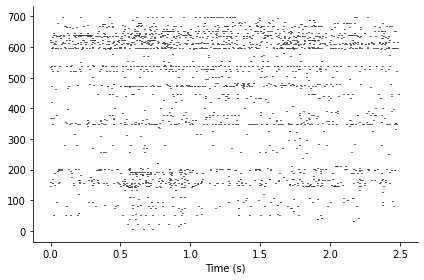

In [19]:
# @title Raster Plot
# !!! Retrieve and load the continuous spike time data first

neuron_idx = np.arange(0, len(dat_ST['ss'][:,50]), 1)
# neuron_idx = 87
raster_plot(dat_ST['ss'][:,50], neuron_idx)

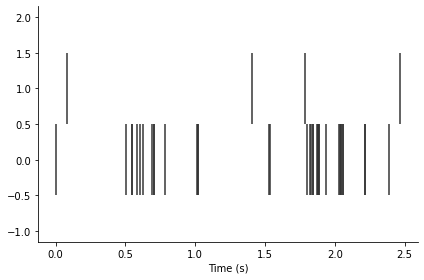

Reference Neuron [0.08044791 1.404648   1.7849146  2.4689813 ]
Target Neuron [1.1145817e-03 5.0188124e-01 5.4424793e-01 5.5074793e-01 5.8011460e-01
 6.0658127e-01 6.2778127e-01 6.8934792e-01 7.0194793e-01 7.0601457e-01
 7.8301460e-01 1.0154146e+00 1.0182812e+00 1.0235479e+00 1.5318812e+00
 1.5356812e+00 1.8035812e+00 1.8253813e+00 1.8310146e+00 1.8441813e+00
 1.8464479e+00 1.8730812e+00 1.8761146e+00 1.8810480e+00 1.8837479e+00
 1.8864145e+00 1.9375479e+00 2.0286479e+00 2.0348814e+00 2.0440147e+00
 2.0463812e+00 2.0573480e+00 2.0604479e+00 2.2124813e+00 2.2169480e+00
 2.3846478e+00]

Multiple Target Spikes
REFERENCE:  1.7849146
TARGET:  1.8035812
REFERENCE:  1.7849146
TARGET:  1.8253813
REFERENCE:  1.7849146
TARGET:  1.8310146
Total Spikes:  3

Multiple Reference Spikes
REFERENCE:  1.8035812
TARGET:  1.7849146
REFERENCE:  1.8253813
TARGET:  1.7849146
REFERENCE:  1.8310146
TARGET:  1.7849146
Total Spikes:  3


In [20]:
# @title Single Trial Spike Count
ref = dat_ST['ss'][87,50]
tar = dat_ST['ss'][145,50]
synch_width = 50 # in msec

# For visual investigation
neuron_idx = [145,87]
raster_plot(dat_ST['ss'][:,50], neuron_idx)
print("Reference Neuron", ref)
print("Target Neuron",tar)
# ---------------------------------------

# Multiple Target Spikes
print("\nMultiple Target Spikes")
print("Total Spikes: ",spike_count(ref,tar,synch_width,True))

#Multiple Reference Spikes
print("\nMultiple Reference Spikes")
print("Total Spikes: ",spike_count(tar,ref,synch_width,True))

Region: ACA


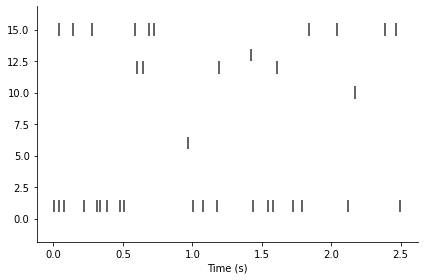

Region: CA1


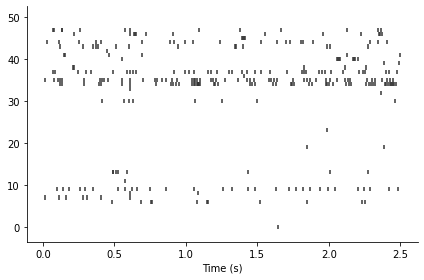

Region: DG


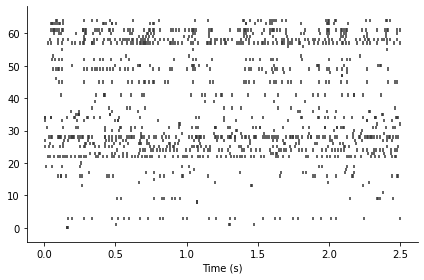

Region: LGd


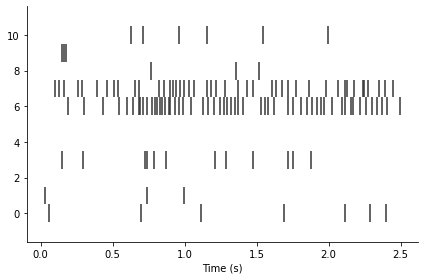

Region: LH


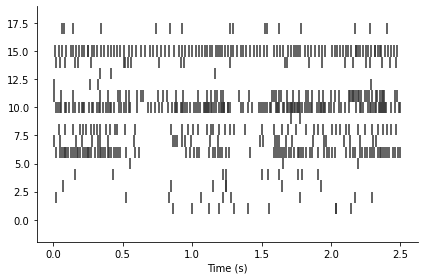

Region: MD


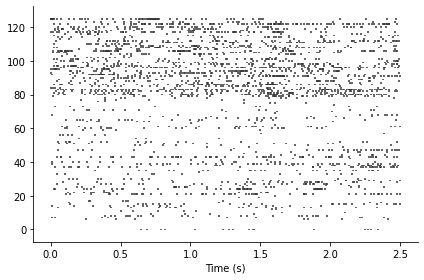

Region: MOs


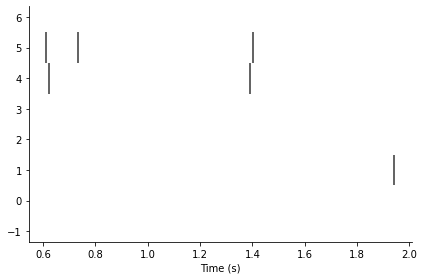

Region: PL


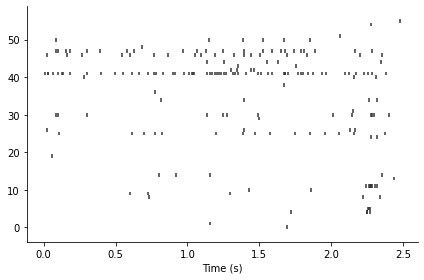

Region: SUB


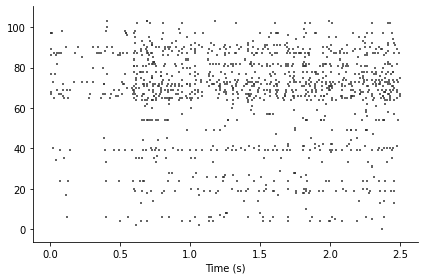

Region: VISam


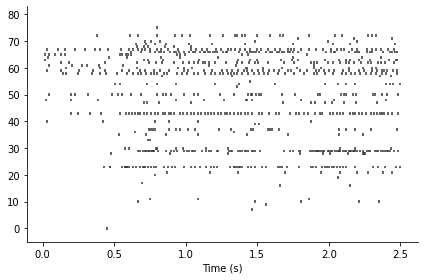

Region: VISp


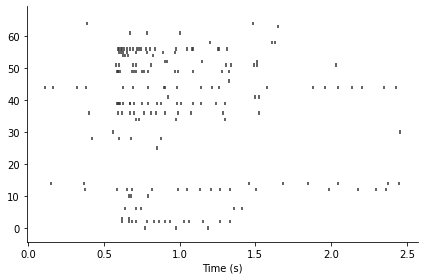

Region: root


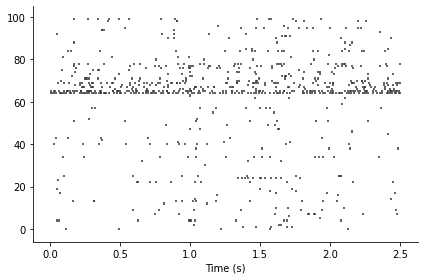

In [21]:
# @title Extract Brain Regions From the Dataset

session = 11
data, selected_areas = extract_areas(alldat, alldat_ST, session)

for j in range (len(selected_areas)):
  plt.figure(j)
  print("Region:", selected_areas[j])
  p,_, = data[selected_areas[j]].shape
  spike_times = data[selected_areas[j]][:,5]
  neuron_idx = np.arange(0, len(spike_times), 1)
  raster_plot(spike_times, neuron_idx)

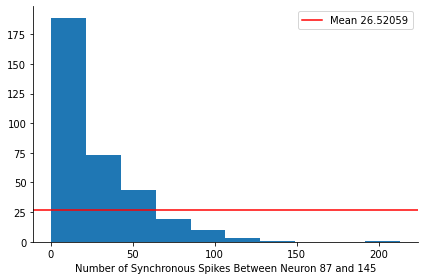

Average Over Trials: 26.52059


In [22]:
# @title Average Over Trials and Histogram

trial_size = np.size(dat_ST['ss'], axis = 1)
synch_width = 500 # in msec
trial = np.zeros(trial_size)

for i in range(trial_size):
  ref = dat_ST['ss'][87,i]
  tar = dat_ST['ss'][145,i]
  trial[i] = spike_count(ref, tar, synch_width)

plt.hist(trial)
plt.axhline(np.mean(trial), color = 'r', label = "Mean {:.5f}".format(np.mean(trial)))
plt.xlabel("Number of Synchronous Spikes Between Neuron 87 and 145")
plt.legend()
plt.show()

average_over_trials(dat_ST['ss'][87,:], dat_ST['ss'][145,:], synch_width)
print("Average Over Trials: {:.5f}".format(average_over_trials(dat_ST['ss'][87,:], dat_ST['ss'][145,:], synch_width)))

In [23]:
# @title Average On A Region Heat Map
# (region ->(neuron, trial)) dictionary
data, areas = extract_areas(alldat, alldat_ST) 
synch_width = 5000 # in msec
reg = 0
test_size = np.size(data[areas[reg]], axis = 0)
title = "Average Synchronous Spike Count Between Neurons in \
{} region ".format(areas[reg])
# ------------------       

test = analyse_region(data, areas[reg], synch_width)
heat_map_annotated(test, title, save_fig = True)

In [24]:
# Testing the function for null distribution based on two neurons in ACA
# 0 11 - bad example (NEED TO DISCUSS)
# 1 12 - good example

calc_null_distribution(data['ACA'][12], data['ACA'][15], jitter_width = 0.01, \
                       synch_width = 5, n_iterations = 200, sig_percentile = 95)

(0.12352941176470589, array([[0.10588235],
        [0.15      ],
        [0.11470588],
        [0.11176471],
        [0.11176471],
        [0.10294118],
        [0.10588235],
        [0.12352941],
        [0.09705882],
        [0.09705882],
        [0.09411765],
        [0.09705882],
        [0.08235294],
        [0.1       ],
        [0.12058824],
        [0.09117647],
        [0.09117647],
        [0.10882353],
        [0.10882353],
        [0.08235294],
        [0.07941176],
        [0.10588235],
        [0.12058824],
        [0.10588235],
        [0.10588235],
        [0.11764706],
        [0.08529412],
        [0.12058824],
        [0.08529412],
        [0.10882353],
        [0.11764706],
        [0.09117647],
        [0.1       ],
        [0.1       ],
        [0.1       ],
        [0.10294118],
        [0.10588235],
        [0.10588235],
        [0.12352941],
        [0.10588235],
        [0.11470588],
        [0.09411765],
        [0.11470588],
        [0.10588235],
        [0.

In [25]:
ndata, selected_areas = extract_areas(alldat, alldat_ST, session = 11)
print(ndata.keys())

dict_keys(['ACA', 'CA1', 'DG', 'LGd', 'LH', 'MD', 'MOs', 'PL', 'SUB', 'VISam', 'VISp', 'root'])


In [26]:
# @title FULL PIPELINE

area = ('ACA','MOs')
full_pipeline(ndata, area, synch_width = 5, jitter_width = 0.01, path = "./drive/My Drive/spike_2/")
analyze_data(path = "./drive/My Drive/spike_2/", areapair = area, heat = True, saveFig = True)

Connectivity between ('ACA', 'MOs') is 0.0%
